# Setup

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [3]:
''' Define plotting defaults '''
from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
''' Define function to retrieve spike depths along the probe using template waveforms '''

def get_spike_depths(temps, winv, ycoords, spikeTemplates):
    
    ''' 
    Compute spike depths for each cluster

    Params
    ------ 
    temps: the templates (nTemplates x nTimePoints x nChannels)
    winv: the whitening matrix (nCh x nCh)
    ycoords: the coordinates of the channels (nCh x 1)
    spikeTemplates: which template each spike came from (nSpikes x 1)

    Returns
    --------
    spikeDepths is the position along the probe of every spike, (nSpikes x 1)
    according to the position of the template it was extracted with. Distance in microns from tip.

    '''
    #unwhiten all templates
    tempsUnW = np.zeros(shape = (temps.shape[0],temps.shape[1],temps.shape[2]))
    for t in range(0,temps.shape[0]):
        tempsUnW[t,:,:] = np.matmul(temps[t,:,:],winv)

    #get the amplitude on each channel as the max minus min in timepoints (shape nTemp x nCh)
    tempChanAmps = np.max(tempsUnW, axis = 1) - np.min(tempsUnW, axis = 1)

    #the template amplitude is the amplitude of the largest channel 
    tempAmpsUnscaled = np.max(tempChanAmps, axis = 1) #shape nTemp

    #zero out potentially many low values on distant channels; for every channel if below amp 
    threshVals = tempAmpsUnscaled*0.3
    for i in range(0,tempChanAmps.shape[1]):
        for j in range(0,len(threshVals)):
            if tempChanAmps[j,i] < threshVals[j]:
                tempChanAmps[j,i] = 0

    #compute template depth as a center of mass
    templateDepths = np.sum(tempChanAmps*ycoords, axis = 1) / (np.sum(tempChanAmps, axis = 1))

    #each spikes depth is the depth of its template
    spikeDepths = templateDepths[templates]
    
    return spikeDepths

In [5]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [6]:
'''Load Session Metadata'''
sessionmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/SessionMetadata.csv') # adjust path name

In [7]:
''' Complete List of Mice & Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_record excluded for syncing issue, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [8]:
'''Define which mice & sessions to load'''
mice = all_mice
sessions = all_sessions
    
# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

# Edit these paths

In [9]:
#Inputs
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # adjust path to match output of Import & Filter
shuffload_folder1 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/speedscores/' # adjust to match location of this Dryad repo folder
shuffload_folder2 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/speedstabscores/' # adjust to match location of this Dryad repo folder
fig2s3_folder = 'C:/Users/Python/Desktop/LocalData/Figure2S3/' # adjust to match Figure 2/S3 output folder
int_save_folder = 'C:/Users/Python/Desktop/LocalData/FigureS6/' # adjust to match Shuffle Procedure output plotsave_folder

#Output (create folder to hold the output of this notebook; then match the name of this repository below)
save_folder = 'C:/Users/Python/Desktop/LocalData/Figure6/' 

In [10]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

In [11]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,17)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,18)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in all_aged_mice:
            idx = np.where(all_aged_mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in all_MA_mice:
            idx = np.where(all_MA_mice == m)[0][0]
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(all_young_mice == m)[0][0]
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y2','Y3','Y4','Y11','Y16','Y17','Y18','Y19','Y9', 'Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28',
            'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F','MA10F',"","","","","","","",
            'A3','A4','A5','A6','A7','A12','A13','A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# Classify positively and negatively speed-tuned (+ / - speed) cells 

In [14]:
''' Calculate & Save Real Speed Scores & Speed Stability Scores '''
realspeedscores = []
realspeedstabscores = []
dt = 0.02
sigma = 20  # smoothing factor for instantaneous firing rate
n_bin = 8 #n position bins considered for speed stability score
track_length = 400 #cm
bins = np.arange(0,track_length + (track_length/n_bin),(track_length/n_bin))

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        posxfil = behaviorfil[:,0]
        Y = np.load(load_folder + spikes_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        speed = behaviorfil[:,1] #already filtered through gaussian (10 timebins) 
        
        # divide all obs into 8 x 50 cm bins
        bin_idx = []
        for i in range(n_bin):
            if i == (n_bin - 1):
                idx = np.where((posxfil >= bins[i]) & (posxfil <= bins[i + 1]))[0]
            else:
                idx = np.where((posxfil >= bins[i]) & (posxfil < bins[i + 1]))[0]
            bin_idx.append(idx)
        
        #get smoothed spike train, calculate speed score
        A = np.zeros((len(speed), len(cell_IDs)))
        realspeed_score = []
        realspeedstab_score = []
        for i, c in enumerate(cell_IDs):
            A[:,i] = Y[:,i]
            A[:,i] = gaussian_filter1d(A[:,i],sigma)
            
            #calculate speed score
            sscore, _ = stats.pearsonr(A[:,i],speed)
            realspeed_score = np.append(realspeed_score,sscore)
            
            #calculate & store speed stability score for this cell's smoothed spike train
            bin_pspikes = []
            for j in range(n_bin):
                idx = bin_idx[j]
                psscore, _ = stats.pearsonr(A[idx,i],speed[idx])
                bin_pspikes = np.append(bin_pspikes, (psscore *  np.sum(A[idx,i])))

            sstabscore = np.sum(bin_pspikes) / np.sum(A[:,i])
            realspeedstab_score = np.append(realspeedstab_score,sstabscore)
            
        d['speedscore'] = realspeed_score
        d['speedstabscore'] = realspeedstab_score
        d['A'] = A

        #Save stuff
        realinstspeedscore_file = 'realinstspeedscore_' + m + '_' + s + '.npy'
        realspeedstabscore_file = 'realspeedstabscore_' + m + '_' + s + '.npy'
        A_file = 'A_' + m + '_' + s + '.npy'
        
        np.save(save_folder + realinstspeedscore_file, realspeed_score)
        #print('saved real speed score data as npy file for mouse ' + m + ' session '+ s)
        np.save(save_folder + realspeedstabscore_file, realspeedstab_score)
        #print('saved real speed stability score data as npy file for mouse ' + m + ' session '+ s)
        np.save(save_folder + A_file, A)
        #print('saved filtered, binned spikes as npy file for mouse ' + m + ' session '+ s)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
'''Load Scores & Save Booleans of Negative & Positively Modulated Speed Cells 
  
 NOTE: shuffled scores are produced by the notebook "Shuffle Procedure." Please run that for all sessions before proceeding here.

'''  

P99score = []
P99stabscore = []
for m, session in zip(mice,sessions):
    for s in session:
        d = data[m][s]
    
        #get file names
        realspeedscore_file = 'realinstspeedscore_' + m + '_' + s + '.npy'
        realspeedstabscore_file = 'realspeedstabscore_' + m + '_' + s + '.npy'
        shufinstspeedscore_file = 'shufinstspeedscore_' + m + '_' + s + '.npy'
        shufspeedstabscore_file = 'shufspeedstabscore_' + m + '_' + s + '.npy'
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        
        #Load stuff & get data relevant to classification
        d['speedscore'] = np.load(save_folder + realspeedscore_file)
        d['speedstabscore'] = np.load(save_folder + realspeedstabscore_file)
        d['shufspeedscore'] = np.load(shuffload_folder1 + shufinstspeedscore_file, allow_pickle = True) 
        d['shufspeedstabscore'] = np.load(shuffload_folder2 + shufspeedstabscore_file, allow_pickle = True) 
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        shufspeedscore = d['shufspeedscore']
        shufspeedstabscore = d['shufspeedstabscore']
        realspeed_score = d['speedscore'] 
        realspeedstab_score = d['speedstabscore'] 
        cell_IDs = raw.item().get('cellsfil')
        
        speedcell99 = []
        speedcell1 = []
        
        #Classify excitatory, positively & negatively modulated speed cells
        for i, c in enumerate(cell_IDs):
            dist = abs(shufspeedscore[:,i])
            P99 = np.percentile(dist,99)
            
            dist2 = abs(shufspeedstabscore[:,i])
            sP99 = np.percentile(dist2,99)
            
            P99stabscore = np.append(P99stabscore, sP99)
            P99score = np.append(P99score, P99)

            if (abs(realspeed_score[i]) >= P99) & (abs(realspeedstab_score[i]) >= sP99):
                if realspeed_score[i] >= 0: # pos mod P99 cell
                    speedcell99 = np.append(speedcell99, True)
                    speedcell1 = np.append(speedcell1, False)
                else: # neg mod P99 cell
                    speedcell99 = np.append(speedcell99, False)
                    speedcell1 = np.append(speedcell1, True) 
            else:
                speedcell99 = np.append(speedcell99, False)
                speedcell1 = np.append(speedcell1, False) 

        speedcell99 = np.asarray(speedcell99).astype(bool)
        speedcell1 = np.asarray(speedcell1).astype(bool)
                
        #save speed cell classification boolean as .npy file for easy access for all animals
        d['speedcell99'] = speedcell99
        d['speedcell1'] = speedcell1
        
        #speedcell99_file = 'speedcell99_' + m + '_' + s + '.npy'
        #speedcell1_file = 'speedcell1_' + m + '_' + s + '.npy'
        
        #np.save(save_folder + speedcell99_file, speedcell99)
        #np.save(save_folder + speedcell1_file, speedcell1)
        print('saved all speed cell booleans as npy files for mouse ' + m + ' session '+ s)

saved all speed cell booleans as npy files for mouse A3 session 0122_record1
saved all speed cell booleans as npy files for mouse A3 session 0123_record2
saved all speed cell booleans as npy files for mouse A3 session 0124_record3
saved all speed cell booleans as npy files for mouse A3 session 0125_record4
saved all speed cell booleans as npy files for mouse A3 session 0126_record5
saved all speed cell booleans as npy files for mouse A3 session 0127_record6
saved all speed cell booleans as npy files for mouse A4 session 0122_record1
saved all speed cell booleans as npy files for mouse A4 session 0123_record2
saved all speed cell booleans as npy files for mouse A4 session 0124_record3
saved all speed cell booleans as npy files for mouse A4 session 0125_record4
saved all speed cell booleans as npy files for mouse A4 session 0126_record5
saved all speed cell booleans as npy files for mouse A4 session 0127_record6
saved all speed cell booleans as npy files for mouse A5 session 0401_record1

saved all speed cell booleans as npy files for mouse A18 session 082322_record1real
saved all speed cell booleans as npy files for mouse A18 session 082422_record2
saved all speed cell booleans as npy files for mouse A18 session 082522_record3
saved all speed cell booleans as npy files for mouse A18 session 082622_record4
saved all speed cell booleans as npy files for mouse A18 session 082722_record5
saved all speed cell booleans as npy files for mouse A18 session 082822_record6
saved all speed cell booleans as npy files for mouse MA1F session 102322_record1
saved all speed cell booleans as npy files for mouse MA1F session 102422_record2
saved all speed cell booleans as npy files for mouse MA1F session 102522_record3
saved all speed cell booleans as npy files for mouse MA1F session 102622_record4
saved all speed cell booleans as npy files for mouse MA1F session 102722_record5
saved all speed cell booleans as npy files for mouse MA1F session 102822_record6
saved all speed cell booleans 

saved all speed cell booleans as npy files for mouse A20 session 012823_record3
saved all speed cell booleans as npy files for mouse A20 session 012923_record4
saved all speed cell booleans as npy files for mouse A20 session 013023_record5
saved all speed cell booleans as npy files for mouse A20 session 013123_record6
saved all speed cell booleans as npy files for mouse A22 session 012923_record2
saved all speed cell booleans as npy files for mouse A22 session 013023_record3
saved all speed cell booleans as npy files for mouse A22 session 013123_record4
saved all speed cell booleans as npy files for mouse A22 session 020123_record5
saved all speed cell booleans as npy files for mouse A22 session 020223_record6
saved all speed cell booleans as npy files for mouse A22 session 020323_record7
saved all speed cell booleans as npy files for mouse A23 session 020923_record1
saved all speed cell booleans as npy files for mouse A23 session 021023_record2
saved all speed cell booleans as npy fil

In [13]:
'''Load Scores & Save Booleans of Negative & Positively Modulated Speed Cells 
  
 NOTE: shuffled scores are produced by the notebook "Shuffle Procedure." Please run that for all sessions before proceeding here.

'''  

P95score = []
P95stabscore = []
for m, session in zip(mice,sessions):
    for s in session:
        d = data[m][s]
    
        #get file names
        realspeedscore_file = 'realinstspeedscore_' + m + '_' + s + '.npy'
        realspeedstabscore_file = 'realspeedstabscore_' + m + '_' + s + '.npy'
        shufinstspeedscore_file = 'shufinstspeedscore_' + m + '_' + s + '.npy'
        shufspeedstabscore_file = 'shufspeedstabscore_' + m + '_' + s + '.npy'
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        
        #Load stuff & get data relevant to classification
        d['speedscore'] = np.load(save_folder + realspeedscore_file)
        d['speedstabscore'] = np.load(save_folder + realspeedstabscore_file)
        d['shufspeedscore'] = np.load(shuffload_folder1 + shufinstspeedscore_file, allow_pickle = True) 
        d['shufspeedstabscore'] = np.load(shuffload_folder2 + shufspeedstabscore_file, allow_pickle = True) 
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        shufspeedscore = d['shufspeedscore']
        shufspeedstabscore = d['shufspeedstabscore']
        realspeed_score = d['speedscore'] 
        realspeedstab_score = d['speedstabscore'] 
        cell_IDs = raw.item().get('cellsfil')
        
        speedcell95 = []
        speedcell5 = []
        
        #Classify excitatory, positively & negatively modulated speed cells
        for i, c in enumerate(cell_IDs):
            dist = abs(shufspeedscore[:,i])
            P95 = np.percentile(dist,95)
            
            dist2 = abs(shufspeedstabscore[:,i])
            sP95 = np.percentile(dist2,95)
            
            P95stabscore = np.append(P95stabscore, sP95)
            P95score = np.append(P95score, P95)

            if (abs(realspeed_score[i]) >= P95) & (abs(realspeedstab_score[i]) >= sP95):
                if realspeed_score[i] >= 0: # pos mod P95 cell
                    speedcell95 = np.append(speedcell95, True)
                    speedcell5 = np.append(speedcell5, False)
                else: # neg mod P95 cell
                    speedcell95 = np.append(speedcell95, False)
                    speedcell5 = np.append(speedcell5, True) 
            else:
                speedcell95 = np.append(speedcell95, False)
                speedcell5 = np.append(speedcell5, False) 

        speedcell95 = np.asarray(speedcell95).astype(bool)
        speedcell5 = np.asarray(speedcell5).astype(bool)
                
        #save speed cell classification boolean as .npy file for easy access for all animals
        d['speedcell95'] = speedcell95
        d['speedcell5'] = speedcell5
        
        #speedcell95_file = 'speedcell95_' + m + '_' + s + '.npy'
        #speedcell5_file = 'speedcell5_' + m + '_' + s + '.npy'
        
        #np.save(save_folder + speedcell95_file, speedcell95)
        #np.save(save_folder + speedcell5_file, speedcell5)
        #print('saved all speed cell booleans as npy files for mouse ' + m + ' session '+ s)

In [16]:
''' Total of Cells of Each Type by Age Group at P99 Thresholds'''

ypos = 0
mapos = 0
apos = 0

yneg = 0
maneg = 0
aneg = 0 

for m, session in zip(mice,sessions):    
    for s in session:
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        poscell = d['speedcell99']
        negcell = d['speedcell1']
        
        poscell = poscell.astype(bool)
        negcell = negcell.astype(bool)
        
        if (m in all_aged_mice):
            apos += np.sum(poscell)
            aneg += np.sum(negcell)
        elif m in SM_MA_mice:
            mapos += np.sum(poscell)
            maneg += np.sum(negcell)
        else:
            ypos += np.sum(poscell)
            yneg += np.sum(negcell)
            
print(ypos, mapos, apos)
print(yneg, maneg, aneg)

6522 4062 6507
3085 2071 2912


In [17]:
''' Total of Cells of Each Type by Age Group at P95 Thresholds'''

ypos = 0
mapos = 0
apos = 0

yneg = 0
maneg = 0
aneg = 0 

for m, session in zip(mice,sessions):    
    for s in session:
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        poscell = d['speedcell95']
        negcell = d['speedcell5']
        
        poscell = poscell.astype(bool)
        negcell = negcell.astype(bool)
        
        if m in all_aged_mice:
            apos += np.sum(poscell)
            aneg += np.sum(negcell)
        elif m in SM_MA_mice:
            mapos += np.sum(poscell)
            maneg += np.sum(negcell)
        else:
            ypos += np.sum(poscell)
            yneg += np.sum(negcell)
            
print(ypos, mapos, apos)
print(yneg, maneg, aneg)

7601 4648 7481
3763 2410 3473


# Examine speed tuning among classified speed cells (~Figure 6D-E)

In [20]:
'''Collect Speed Cell FR Slope'''
# set up arrays for plotting by session 
sslope95 = []
sslope5 = []

#arrays for density of +/- speed cells 
sper95 = []
sper5 = []
mper95 = []
mper5 = []

dt = 0.02

for m, session in zip(mice,sessions):
    m_cells = []
    m_95 = []
    m_5 = []
    
    for s in tdqm(session):
        d = data[m][s]
    
        #get file names & load data necessary
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        A_file = 'A_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        A = np.load(save_folder + A_file)
        speed = behaviorfil[:,1]
       
        #get dict-stored data
        cell_IDs = raw.item().get('cellsfil')
        d['intn'] = np.load(int_save_folder + intn_file, allow_pickle = True)
        d['intn'] = d['intn'].astype(bool)
        intn = d['intn']
        
        speedcell95 = d['speedcell95']
        speedcell5 = d['speedcell5']
        speedcells95 = cell_IDs[(speedcell95 == 1) & (intn == 0)]
        speedcells5 = cell_IDs[(speedcell5 == 1) & (intn == 0)]
        
        sper95 = np.append(sper95, 100*len(speedcells95)/len(cell_IDs))
        sper5 = np.append(sper5, 100*len(speedcells5)/len(cell_IDs))
        
        #get slopes for each speed cell population
        slope95 = []
        for i, c in enumerate(speedcells95):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            #get slope/FR and convert to Hz/speed
            slopeFR, intFR, r_value, p_val, std_err = stats.linregress(speed, A[:,sdx])
            slopeFR = slopeFR/dt
            intFR = intFR/dt
            slope95 = np.append(slope95,slopeFR) #FR/speed slope
            
        slope5 = []
        for i, c in enumerate(speedcells5):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            #get slope/FR and convert to Hz/speed
            slopeFR, intFR, r_value, p_val, std_err = stats.linregress(speed, A[:,sdx])
            slopeFR = slopeFR/dt
            intFR = intFR/dt
            slope5 = np.append(slope5,slopeFR) #FR/speed slope
        
        #pool data into session arrays    
        sslope95 = np.append(sslope95, np.mean(slope95))
        sslope5 = np.append(sslope5, np.mean(slope5))
        m_cells = np.append(m_cells, len(cell_IDs))
        m_95 = np.append(m_95, len(speedcells95))
        m_5 = np.append(m_5, len(speedcells5))
        
    mper95 = np.append(mper95, 100*np.sum(m_95)/np.sum(m_cells))
    mper5 = np.append(mper5, 100*np.sum(m_5)/np.sum(m_cells))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [21]:
''' Find where I will have NaNs due to 0% speed cells in a given Session'''
nan_idx95 = np.where((sper95 == 0))[0]
nan_idx5 = np.where((sper5 == 0))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sind95 = np.setdiff1d(y_sind, nan_idx95)
ma_sind95 = np.setdiff1d(ma_sind, nan_idx95)
age_sind95 = np.setdiff1d(age_sind, nan_idx95)

y_sind5 = np.setdiff1d(y_sind, nan_idx5)
ma_sind5 = np.setdiff1d(ma_sind, nan_idx5)
age_sind5 = np.setdiff1d(age_sind, nan_idx5)

#adjust colormaps
yidx = []
maidx = []
aidx = []
for i in nan_idx95:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_young95 = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_ma95 = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_old95 = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session95 = [col_session_young95, col_session_ma95, col_session_old95] 

yidx = []
maidx = []
aidx = []
for i in nan_idx5:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_young5 = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_ma5 = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_old5 = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session5 = [col_session_young5, col_session_ma5, col_session_old5]       

# This will fix how session stats & box plots are plotted, ensuring color schemes are adjusted.

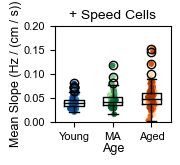

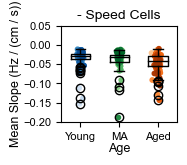

In [27]:
''' Plot Figure 6d '''

#set up handles
from itertools import repeat
handles = []
mper = [mper5[y_ind], mper5[ma_ind], mper5[age_ind]]

for i in range(len(mper)):    
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)
        if c[0] == col_animal[1][0][9][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.extend(repeat(l,7))
               
#Plot Figure 6d (left)
fig, ax = plt.subplots(figsize = (1.5,1.25))
sslope = [sslope95[y_sind95], sslope95[ma_sind95], sslope95[age_sind95]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sslope, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sslope)):
    y = sslope[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session95[i], edgecolors = col_session95[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ Speed Cells', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Slope (Hz / (cm / s))', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,0.2])
ax.set_yticks([0,0.05,0.1,0.15,0.2])
plt.savefig(save_folder + 'ReviewerFigure7Ileft.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure7Ileft.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Figure 6d (right)
fig, ax = plt.subplots(figsize = (1.5,1.25))
sslope = [sslope5[y_sind5], sslope5[ma_sind5], sslope5[age_sind5]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sslope, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sslope)):
    y = sslope[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session5[i], edgecolors = col_session5[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('- Speed Cells', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Slope (Hz / (cm / s))', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([-0.2,0.05])
ax.set_yticks([-0.2,-0.15,-0.1,-0.05,0, 0.05])
plt.savefig(save_folder + 'ReviewerFigure7Iright.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure7Iright.svg', dpi=400, bbox_inches='tight')
plt.show()

In [23]:
''' Statistics for Figure 6d (left) '''
print('\nn young, MA, sessions with + speed cells:')
print(len(y_sind95),len(ma_sind95), len(age_sind95))

print('\nspeedcellslopeyoung ± SEM; speedcellslope_MA ± SEM; speedcellslope_old ± SEM')
print(str(np.round(np.mean(sslope95[y_sind95]), 4)) + ' ± ' + str(np.round(stats.sem(sslope95[y_sind95]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope95[ma_sind95]), 4)) + ' ± ' + str(np.round(stats.sem(sslope95[ma_sind95]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope95[age_sind95]), 4)) + ' ± ' + str(np.round(stats.sem(sslope95[age_sind95]), 4)))

stat, p_diff = stats.kruskal(sslope95[y_sind95],sslope95[ma_sind95],sslope95[age_sind95])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

#get what you need for multiple comparisons
import statsmodels.api as sm
import scikit_posthocs as ph

#make into dataframe
seshmice = []
seshcount = []
seshage = []
for m, session in zip(mice, sessions):
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    totalsesh = len(session)
    
    for i, s in enumerate(session):
        seshmice = np.append(seshmice, m)
        seshcount = np.append(seshcount, (i + 1))
        seshage = np.append(seshage, age)

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind95,ma_sind95,age_sind95))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Slopepos = list(sslope95[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Slopepos))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','slopepos'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'slopepos', group_col = 'AgeGroup', p_adjust = 'holm')


n young, MA, sessions with + speed cells:
97 58 96

speedcellslopeyoung ± SEM; speedcellslope_MA ± SEM; speedcellslope_old ± SEM
0.0404 ± 0.0012 ; 0.0463 ± 0.0023 ; 0.0513 ± 0.0024
stat = 16.312979173791746
p_session = 0.00028686765329807314


,1.0,2.0,3.0
1.0,1.000000,0.089730,0.000135
2.0,0.089730,1.000000,0.114657
3.0,0.000135,0.114657,1.000000


In [24]:
''' Statistics for Figure 6d (right) '''
print('\nn young, MA, sessions with - speed cells:')
print(len(y_sind5),len(ma_sind5), len(age_sind5))

print('speedcellslopeyoung ± SEM; speedcellslope_MA ± SEM; speedcellslope_old ± SEM')
print(str(np.round(np.mean(sslope5[y_sind5]), 4)) + ' ± ' + str(np.round(stats.sem(sslope5[y_sind5]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope5[ma_sind5]), 4)) + ' ± ' + str(np.round(stats.sem(sslope5[ma_sind5]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope5[age_sind5]), 4)) + ' ± ' + str(np.round(stats.sem(sslope5[age_sind5]), 4)))

stat, p_diff = stats.kruskal(sslope5[y_sind5],sslope5[ma_sind5],sslope5[age_sind5])
print('stat = ' + str(stat))
print('p_session = ' + str(p_diff))

#NEGATIVE
# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind5,ma_sind5,age_sind5))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Slopeneg = list(sslope5[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Slopeneg))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','slopeneg',])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'slopeneg', group_col = 'AgeGroup', p_adjust = 'holm')


n young, MA, sessions with - speed cells:
96 58 96
speedcellslopeyoung ± SEM; speedcellslope_MA ± SEM; speedcellslope_old ± SEM
-0.0338 ± 0.0023 ; -0.04 ± 0.0038 ; -0.0461 ± 0.0025
stat = 22.712326555845607
p_session = 1.1697174068713999e-05


,1.0,2.0,3.0
1.0,1.000000,0.052590,0.000004
2.0,0.052590,1.000000,0.037221
3.0,0.000004,0.037221,1.000000


In [28]:
''' Collect Speed Cell Trial Stability Score 

Run time: 10-15 seconds / session x 250 sessions with either type of speed cell (~ 1 hr).

'''
# set up arrays for plotting by session 
strialstabscore5 = []
strialstabscore95 = []

dt = 0.02

for m, session in zip(mice,sessions):
    
    for s in tdqm(session):
        d = data[m][s]
    
        #get file names & load data necessary
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        A_file = 'A_' + m + '_' + s + '.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        A = np.load(save_folder + A_file)
        speed = behaviorfil[:,1]
        trial = behaviorfil[:,2]
       
        #get dict-stored data
        cell_IDs = raw.item().get('cellsfil')
        intn = d['intn'].astype(bool)
        speedcell95 = d['speedcell95']
        speedcell5 = d['speedcell5']
        speedcells95 = cell_IDs[(speedcell95 == 1) & (intn == 0)]
        speedcells5 = cell_IDs[(speedcell5 == 1) & (intn == 0)]
        
        #get spike-weighted average of speed score by trial for each speed cell population
        bytrialspeedstabilityscores95 = []          
        for i, c in enumerate(speedcells95):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            weightscore = []
            for j, t in enumerate(np.unique(trial)):
                trialidx = np.where(trial == t)[0].astype(int)
                
                trialscore, _ = stats.pearsonr(speed[trialidx], A[trialidx,sdx])
                weightscore = np.append(weightscore, trialscore * np.sum(A[trialidx,sdx]))   
            bytrialspeedstabilityscores95 = np.append(bytrialspeedstabilityscores95, np.nansum(weightscore) / np.sum(A[:,sdx]))
            
        bytrialspeedstabilityscores5 = []
        for i, c in enumerate(speedcells5):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            weightscore = []
            for j, t in enumerate(np.unique(trial)):
                trialidx = np.where(trial == t)[0].astype(int)
                trialscore, _ = stats.pearsonr(speed[trialidx], A[trialidx,sdx])
                weightscore = np.append(weightscore, trialscore * np.sum(A[trialidx,sdx]))
        
            bytrialspeedstabilityscores5 = np.append(bytrialspeedstabilityscores5, np.nansum(weightscore) / np.sum(A[:,sdx]))

        strialstabscore95 = np.append(strialstabscore95, np.mean(bytrialspeedstabilityscores95))
        strialstabscore5 = np.append(strialstabscore5, np.mean(bytrialspeedstabilityscores5))

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

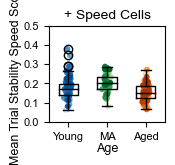

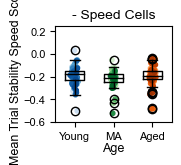

In [37]:
''' Plot Figure 6E '''

#Figure 6E (left)
fig, ax = plt.subplots(figsize = (1.5,1.25))
sttscore = [strialstabscore95[y_sind95], strialstabscore95[ma_sind95], strialstabscore95[age_sind95]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sttscore, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sttscore)):
    y = sttscore[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session95[i], edgecolors = col_session95[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ Speed Cells', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Trial Stability Speed Score', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,0.5])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
plt.savefig(save_folder + 'ReviewerFigure7Jleft.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure7Jleft.svg', dpi=400, bbox_inches='tight')
plt.show()

#Figure 6E (right)
fig, ax = plt.subplots(figsize = (1.5,1.25))
sttscore = [strialstabscore5[y_sind5], strialstabscore5[ma_sind5], strialstabscore5[age_sind5]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sttscore, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sttscore)):
    y = sttscore[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session5[i], edgecolors = col_session5[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('- Speed Cells', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Trial Stability Speed Score', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([-0.6,0.25])
ax.set_yticks([-0.6, -0.4, -0.2, 0, 0.2])
plt.savefig(save_folder + 'ReviewerFigure7Jright.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'ReviewerFigure7Jright.svg', dpi=400, bbox_inches='tight')
plt.show()

In [38]:
''' Stats for Figure 6e (left)'''

print('\nPOS SPEED CELL RESULTS:')
print('meanyoung ± SEM; mean_MA ± SEM; mean_old ± SEM')
print(str(np.round(np.mean(strialstabscore95[y_sind95]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore95[y_sind95]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore95[ma_sind95]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore95[ma_sind95]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore95[age_sind95]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore95[age_sind95]), 4)))

stat, p_diff = stats.kruskal(strialstabscore95[y_sind95],strialstabscore95[ma_sind95],strialstabscore95[age_sind95])
print('stat = ' + str(stat))
print('p_trialstabscore = ' + str(p_diff))

#POSTIVE
# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind95,ma_sind95,age_sind95))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Scorepos = list(strialstabscore95[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Scorepos))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','scorepos'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'scorepos', group_col = 'AgeGroup', p_adjust = 'holm')



POS SPEED CELL RESULTS:
meanyoung ± SEM; mean_MA ± SEM; mean_old ± SEM
0.1731 ± 0.0056 ; 0.1999 ± 0.006 ; 0.156 ± 0.0045
stat = 28.96607462804195
p_trialstabscore = 5.129757242625391e-07


,1.0,2.0,3.0
1.0,1.000000,3.011426e-04,3.394865e-02
2.0,0.000301,1.000000e+00,1.081300e-07
3.0,0.033949,1.081300e-07,1.000000e+00


In [39]:
''' Stats for Figure 6e (right)'''

print('\nNEG SPEED CELL RESULTS:')
print('meanyoung ± SEM; mean_MA ± SEM; mean_old ± SEM')
print(str(np.round(np.mean(strialstabscore5[y_sind5]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore5[y_sind5]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore5[ma_sind5]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore5[ma_sind5]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore5[age_sind5]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore5[age_sind5]), 4)))

stat, p_diff = stats.kruskal(strialstabscore5[y_sind5],strialstabscore5[ma_sind5],strialstabscore5[age_sind5])
print('stat = ' + str(stat))
print('p_trialstabscore = ' + str(p_diff))

#NEGATIVE
# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind5,ma_sind5,age_sind5))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Scoreneg = list(strialstabscore5[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Scoreneg))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','scoreneg'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'scoreneg', group_col = 'AgeGroup', p_adjust = 'holm')


NEG SPEED CELL RESULTS:
meanyoung ± SEM; mean_MA ± SEM; mean_old ± SEM
-0.1893 ± 0.0076 ; -0.2183 ± 0.0098 ; -0.1923 ± 0.0079
stat = 7.97039442231096
p_trialstabscore = 0.018588778046836854


,1.0,2.0,3.0
1.0,1.000000,0.017911,0.561146
2.0,0.017911,1.000000,0.048342
3.0,0.561146,0.048342,1.000000
